In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from geopy import distance
import geopandas
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from keras import metrics

c:\Users\navne\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\navne\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\navne\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\navne\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install geopy

In [2]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

# Assignment 4 - Simple Neural Networks

For this assigment you'll do a realistic task - predicting fraud from transaction data. 
### Some Things to Note

<ul>
<li> The dataset is imbalanced. See: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for some ideas
<li> The locations, time, dob all likely aren't super useful on their own, but can be made into something more useful without much code or trouble. Think about how it may be useful to represent them. The data doesn't have missing rows, so this is the main data prep portion. 
<li> With respect to the above, and the other data here, we have a lot of rows of data. That means that we can generally handle data that is reasonably wide...
</ul>

### Deliverables

Your final goal is to produce a function that can be called to classify a transaction:
<ul>
<li> Please submit two .ipynb files - one where you did your work, and another that can use your model to make predictions. 
<li> In that prediction file, please ensure:
    <ul>
    <li> You have a function where I can load a file, and the end result is a classificaiton matrix of your prediction accuracy. 
    <li> You load a trained model. There's no training here. 
    <li> Any data prep stuff that is needed for your data should be built in here. I'm going to run a test file that is the exact same setup as the training data.
    <li> I should be able to open the prediction file, load the test data, and click RUN ALL and things should work. 
    <li> In addition to that, please include a short (~1-2 paragraph) description of what you did. Include anything that was innovative/different as well as a note on:
        <ul>
        <li> Any imbalanced data steps. 
        <li> Treatment of the location and time variables. What did you do to them?
        <li> Model structure (layers/size)
        <li> Any optimization steps included - regularization, dropouts, feature selection, etc...
        </ul>
    </ul>
</ul>

### Grades

The grade breakdown is as follows:

<ul>
<li> Code preduces predictions - 40
<li> Accuracy - 30
<li> Explaination - 20
<li> Balance/variable transformations - 10
</ul>



In [3]:
# Load some data
df = pd.read_csv("https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/fraudTrain.csv.zip")
df.drop(columns={"Unnamed: 0"}, inplace=True)
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
trans_date_trans_time,1296675,1274791,2019-04-22 16:02:01,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc_num,1296675.0,NaN,NaN,NaN,417192042079641088.0,1308806447000789248.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amt,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
first,1296675,352,Christopher,26669,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,1296675,481,Smith,28794,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
street,1296675,983,0069 Robin Brooks Apt. 695,3123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1296675,894,Birmingham,5617,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Deal with Lat/Lon

We can utilize lat/lon of the home and merchant in a useful way?

Note: I left the section headers in from when I did it. You can remove them if you want. 

In [4]:
from geopy.distance import distance
# Define a function to calculate the distance between two points
def calculate_distance(row):
    point1 = (row['lat'], row['long'])
    point2 = (row['merch_lat'], row['merch_long'])
    dist= distance(point1, point2).km
    return dist

# Apply the calculate_distance function to each row of the DataFrame to create a new 'distance' column
df['dist'] = df.apply(calculate_distance, axis=1)

<li>I used the lat and long columns to calculate the distance between the customer's location and the merchant's location. This could be a useful feature for fraud detection, as fraudulent transactions may be more likely to occur when the customer and merchant are located far away from each other.

### Deal with Time

Can we make date/time and the date of birth into something useful?

In [5]:
from dateutil.relativedelta import relativedelta
import datetime
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')# converting to datetime type
# Calculating the age of the customer in years
now = datetime.datetime.now()
df['age'] = df['dob'].apply(lambda x: relativedelta(now, x).years)

In [6]:
# converting to datetime type
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
# Extracting useful features from the trans_date_trans_time column
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['weekday'] = df['trans_date_trans_time'].dt.weekday
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year


<li> from 'dob' ,a new column describing age is calculated which can be a useful feature.As any customer who is much older or younger than the average customer for a particular type of transaction may be more likely to commit fraud.
<li>I extracted various features from the trans_date_trans_time column such as:
<li>Year, month, day, hour, minute and second of the transaction
<li>Weekday of the transaction
<li>These features can be useful in detecting patterns of fraudulent activity.

### Check Target Balance

0    1289169
1       7506
Name: is_fraud, dtype: int64


<AxesSubplot:>

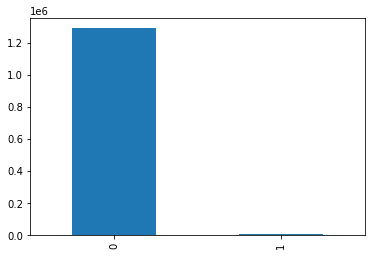

In [12]:
print(df['is_fraud'].value_counts())
df['is_fraud'].value_counts().plot(kind='bar')

In [13]:
# Bincount will count the number in each category
neg, pos = np.bincount(df['is_fraud'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1296675
    Positive: 7506 (0.58% of total)



highly imbalanced target.

### Prepare Data


C:\Users\navne\AppData\Local\Temp\ipykernel_36920\900762441.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['amt'], shade=True)


<AxesSubplot:xlabel='amt', ylabel='Density'>

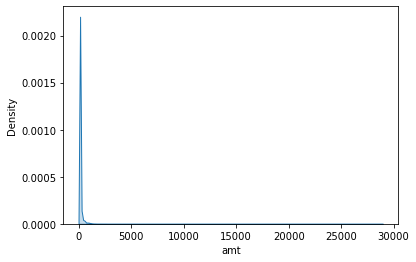

In [11]:
sns.kdeplot(df['amt'], shade=True)

eps is a small constant that is added  to avoid taking the logarithm of zero or negative values, which would result in an error.

eps is set to 0.001, which is a very small value that will not significantly affect the overall distribution of the data. This ensures that the logarithm is only taken for positive values, and that the resulting values are not too extreme.

In [7]:
df = df.drop(columns =['trans_date_trans_time', 'dob', 'lat', 'long', 'merch_lat', 'merch_long',
                       'merchant', 'first', 'last', 'street', 'job','trans_num','unix_time','zip','city_pop','state'])
#started with all features,but considering runtime i have to drop all these

In [8]:
df = pd.get_dummies(df, drop_first=True)

### Split Data

In [9]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('is_fraud'))
val_labels = np.array(val_df.pop('is_fraud'))
test_labels = np.array(test_df.pop('is_fraud'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

### Normalize features

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (829872,)
Validation labels shape: (207468,)
Test labels shape: (259335,)
Training features shape: (829872, 916)
Validation features shape: (207468, 916)
Test features shape: (259335, 916)


### Model

In [14]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
#class_weight = {0: 1.0, 1: total_samples / (num_classes * class_samples)}
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 86.38


In [15]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 350)               320950    
                                                                 
 batch_normalization_8 (Batc  (None, 350)              1400      
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 350)               0         
                                                                 
 dense_19 (Dense)            (None, 350)               122850    
                                                                 
 batch_normalization_9 (Batc  (None, 350)              1400      
 hNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 350)              

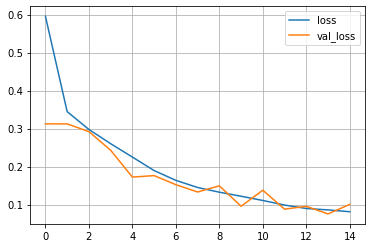

In [29]:
model = keras.Sequential()
model.add(keras.layers.Dense(350, activation='relu',input_shape=(train_features.shape[-1],)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(350, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=METRICS)
#Fit
train_log = model.fit(
  train_features,
  train_labels,
  validation_data=(val_features, val_labels),
  epochs=15,
  batch_size=500,
  callbacks=[callback,lr_scheduler],
  class_weight=class_weight
)
model.evaluate(test_features, test_labels)
plot_loss(train_log)

8105/8105 [==============================] - 23s 3ms/step


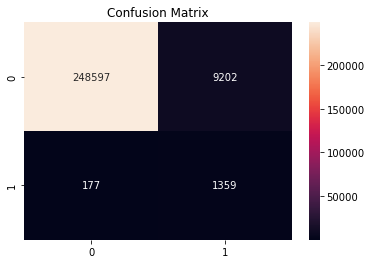

Legitimate Transactions Detected (True Negatives):  248597
Legitimate Transactions Incorrectly Detected (False Positives):  9202
Fraudulent Transactions Missed (False Negatives):  177
Fraudulent Transactions Detected (True Positives):  1359
Total Fraudulent Transactions:  1536


In [30]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Get model predictions for test features
y_pred = model.predict(test_features)
# Convert probabilities to binary labels
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
# Get list of class labels
labels = ['non-fraud', 'fraud']
# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred_binary)
# Plot confusion matrix
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()
print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 350)               320950    
                                                                 
 dropout (Dropout)           (None, 350)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               70200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 391,351
Trainable params: 391,351
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5533/5533 [============================

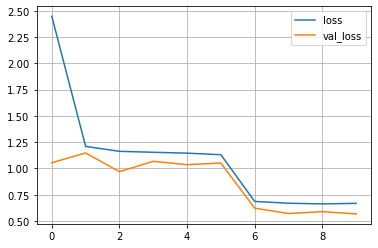

In [16]:
from tensorflow.keras import regularizers
model1= keras.Sequential()
model1.add(keras.layers.Dense(350, activation='relu',input_shape=(train_features.shape[-1],), kernel_regularizer=regularizers.l1_l2(0.01)))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(200, activation='relu',kernel_regularizer=regularizers.l1_l2(0.01)))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias,kernel_regularizer=regularizers.l1_l2(0.01)))
model1.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=METRICS)
#Fit
train_log = model1.fit(
  train_features,
  train_labels,
  validation_data=(val_features, val_labels),
  epochs=10,
  batch_size=150,
  callbacks=[callback,lr_scheduler],
  class_weight=class_weight
)
model1.evaluate(test_features, test_labels)
plot_loss(train_log)

8105/8105 [==============================] - 17s 2ms/step


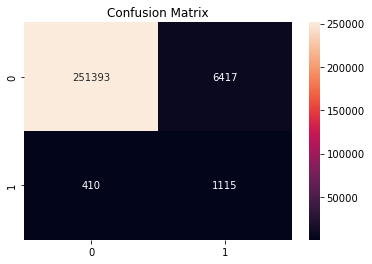

Legitimate Transactions Detected (True Negatives):  251393
Legitimate Transactions Incorrectly Detected (False Positives):  6417
Fraudulent Transactions Missed (False Negatives):  410
Fraudulent Transactions Detected (True Positives):  1115
Total Fraudulent Transactions:  1525


In [17]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Get model predictions for test features
y_pred = model1.predict(test_features)

# Convert probabilities to binary labels
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Get list of class labels
labels = ['non-fraud', 'fraud']

# Compute confusion matrix
cm1 = confusion_matrix(test_labels, y_pred_binary)

# Plot confusion matrix
sns.heatmap(cm1, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()
print('Legitimate Transactions Detected (True Negatives): ', cm1[0][0])
print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm1[0][1])
print('Fraudulent Transactions Missed (False Negatives): ', cm1[1][0])
print('Fraudulent Transactions Detected (True Positives): ', cm1[1][1])
print('Total Fraudulent Transactions: ', np.sum(cm1[1]))

In [18]:
model1.save('FinalModel')

INFO:tensorflow:Assets written to: FinalModel\assets


# Summary of Steps Taken
<li> Imbalanced data steps--intial bias & class weight 
<li> Treatment of the location and time variables.-- from 'dob' ,a new column describing age is calculated.
Year, month, day, hour of the transaction,Weekday of the transaction is calculated from 'date time column'
<li>used the lat and long columns to calculate the distance between the customer's location and the merchant's location.
As fraudulent transactions may be more likely to occur when the customer and merchant are located far away from each other.
<li>log of amount due to skewed distribution.(not using this/didnot give better results)

### Model structure (layers/size)
<li>started with 500 and 3 layers /epochs=30,batch size -64 ,took very long time more than 192 mins and missed values(False ngtv) was huge.
<li>reduced neuron numbers to 350,increased dropout, epochs,batch size(228) and added batch normalization layer,increased patience  led to highly underfitted model.
<li>adjusted learning rate ,decreased batch size (less than 100),epochs,dropout,increased neuron to 350 -still high missed fraud transactions.
<li>decided 3 layers with 350,350,1 neurons , 0.2 dropout ,less epochs, increased batch size  as final model


### Any optimization steps included  
<li>Added a batch normalization layer after each dense layer.
<li>re-trained the model with class weights,intial bias ,end up using both. 
<li>Adjusted layers, number of neurons, epochs,batch size, dropout rate,patience parameter.
<li>Using a learning rate scheduler, ReduceLROnPlateau, to adjust the learning rate during training.
<li> tried applying L1,L2 &L1-l2 regularization with a strength of 0.01 to all the weights in each dense layer but true positive was high but also got too many false positive ,negatives
<li>grid search cv takes forever,could not get results bc of large runtime.